# Winter 2022 & 2023 Wind Events and Sublimation as Measured by SPLASH at Kettle Ponds and Avery Picnic

Author: Daniel Hogan
Created: January 17, 2024

This notebook will look at wind speed, direction, and sublimation for the entire period and build an hourly averaged dataset.
I'll try to answer these three questions:
1) What events had the highest percentile of wind speeds?
2) What were the general storm characteristics? Were they related?
3) How much sublimation over the season came from these events?

### Imports

In [1]:
# general
import os
import glob
import datetime as dt
import json
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, simple_sounding, mean_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
import time
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.3.0


### Let's start by processing Kettle Ponds data
We'll come up with a framework for doing this

In [2]:
# set up the data directory
DATE_FORMAT_STR = '%Y%m%d'
start_date = '20210928' # 20211012
# end_date = '20230509'
end_date = '20230719' # 20230621
PLANAR_FIT = False

datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()
print(datelist)

['20210928', '20210929', '20210930', '20211001', '20211002', '20211003', '20211004', '20211005', '20211006', '20211007', '20211008', '20211009', '20211010', '20211011', '20211012', '20211013', '20211014', '20211015', '20211016', '20211017', '20211018', '20211019', '20211020', '20211021', '20211022', '20211023', '20211024', '20211025', '20211026', '20211027', '20211028', '20211029', '20211030', '20211031', '20211101', '20211102', '20211103', '20211104', '20211105', '20211106', '20211107', '20211108', '20211109', '20211110', '20211111', '20211112', '20211113', '20211114', '20211115', '20211116', '20211117', '20211118', '20211119', '20211120', '20211121', '20211122', '20211123', '20211124', '20211125', '20211126', '20211127', '20211128', '20211129', '20211130', '20211201', '20211202', '20211203', '20211204', '20211205', '20211206', '20211207', '20211208', '20211209', '20211210', '20211211', '20211212', '20211213', '20211214', '20211215', '20211216', '20211217', '20211218', '20211219', '20

In [3]:
def fill_missing_timestamps(ds):
    """
    Modified from Eli Schwat's Sublimpy package.
    
    Fills in missing timestamps in an xr.Dataset for all data variables with NaN values. This is
    particularly useful when multiple daily NetCDF files have been merged together. SPLASH NetCDF files 
    generally have data every 10 minutes. If data is missing from the beginning or end of the day,
    there may be missing timestamps (e.g. if the power was out at the study site between 12am and 2am
    on a day, the first timestamp in the dataset will be 02:02:30). This can be confusing when we want 
    to combine datasets from different days. This function fills in all missing timestamps between the 
    first timestamp and the last timestamp in the provided xr.Dataset. It makes sure there is one 
    timestamp every 5 minutes. 

    Args:
        ds (xr.Dataset): Dataset to be filled. 
    """
    from dateutil.relativedelta import relativedelta
    def date_range(start_date, end_date, increment, period):
        result = []
        nxt = start_date
        delta = relativedelta(**{period:increment})
        while nxt <= end_date:
            result.append(nxt)
            nxt += delta

        return result
    dt_list = date_range(pd.to_datetime(ds.time.values[0]), pd.to_datetime(ds.time.values[-1]), 10, 'minutes')
    ds = ds.drop_duplicates(dim='time').reindex(time=dt_list)

    return ds

In [4]:
# Let's begin by downloading the SPLASH data and storing it in the /storage/ directory
output_dir = '/storage/dlhogan/synoptic_sublimation/splash_data/ASFS-30_Level2_SPLASH2021-2023/'

if not os.path.exists("../../01_data/raw_data/splash_ASFS_KP_all_storage.nc"):
    print("Creating  data file...")
    start = time.time()
    all_file_paths = [
    os.path.join(
        output_dir,
        f'sledseb.asfs30.level2.0.10min.{date}.000000.nc'
    ) for date in datelist
    ]
    datasets = []
    for i,file in enumerate(all_file_paths):
        # check if the file exists
        if not os.path.exists(file):
            print(f"File {file} does not exist")
            continue
        else:
            ds = xr.open_dataset(file).drop_dims(['freq','dfreq'])
            if i == 0:
                ds_attrs = ds.attrs
            # this ensures we don't access variables that aren't in this dataset, which would throw an error
            datasets.append(ds.to_dataframe())
            # for every 10th file, print the time between
            if i % 10 == 0:
                print(f"Time elapsed for 10 files: {time.time()-start}")
                start = time.time()
    splash_df = pd.concat(datasets, axis=0)
    splash_ds = splash_df.to_xarray()
    splash_ds.attrs = ds_attrs
    # ensure time index is evernly spaced by filling in missing times
    splash_ds = fill_missing_timestamps(splash_ds)
    for varname, da in splash_ds.data_vars.items():
        da.attrs = ds[varname].attrs
    splash_ds.to_netcdf("../../01_data/raw_data/splash_ASFS_KP_all_storage.nc")
else:
    print("Loading qc'd data file...")
    splash_kp_ds = xr.open_dataset("../../01_data/raw_data/splash_ASFS_KP_all_storage.nc")

Loading qc'd data file...


In [5]:
# set up the data directory
DATE_FORMAT_STR = '%Y%m%d'
start_date =  '20211012'
# end_date = '20230509'
end_date = '20230621'
PLANAR_FIT = False

datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()
print(datelist)

['20211012', '20211013', '20211014', '20211015', '20211016', '20211017', '20211018', '20211019', '20211020', '20211021', '20211022', '20211023', '20211024', '20211025', '20211026', '20211027', '20211028', '20211029', '20211030', '20211031', '20211101', '20211102', '20211103', '20211104', '20211105', '20211106', '20211107', '20211108', '20211109', '20211110', '20211111', '20211112', '20211113', '20211114', '20211115', '20211116', '20211117', '20211118', '20211119', '20211120', '20211121', '20211122', '20211123', '20211124', '20211125', '20211126', '20211127', '20211128', '20211129', '20211130', '20211201', '20211202', '20211203', '20211204', '20211205', '20211206', '20211207', '20211208', '20211209', '20211210', '20211211', '20211212', '20211213', '20211214', '20211215', '20211216', '20211217', '20211218', '20211219', '20211220', '20211221', '20211222', '20211223', '20211224', '20211225', '20211226', '20211227', '20211228', '20211229', '20211230', '20211231', '20220101', '20220102', '20

In [6]:
# Let's begin by downloading the SPLASH data and storing it in the /storage/ directory
output_dir = '/storage/dlhogan/synoptic_sublimation/splash_data/ASFS-50_Level2_SPLASH2021-2023/'

if not os.path.exists("../../01_data/raw_data/splash_ASFS_AP_all_storage.nc"):
    print("Creating  data file...")
    start = time.time()
    all_file_paths = [
    os.path.join(
        output_dir,
        f'sledseb.asfs50.level2.0.10min.{date}.000000.nc'
    ) for date in datelist
    ]
    datasets = []
    for i,file in enumerate(all_file_paths):
        # check if the file exists
        if not os.path.exists(file):
            print(f"File {file} does not exist")
            continue
        else:
            ds = xr.open_dataset(file).drop_dims(['freq','dfreq'])
            if i == 0:
                ds_attrs = ds.attrs
            # this ensures we don't access variables that aren't in this dataset, which would throw an error
            datasets.append(ds.to_dataframe())
            # for every 10th file, print the time between
            if i % 10 == 0:
                print(f"Time elapsed for 10 files: {time.time()-start}")
                start = time.time()
    splash_df = pd.concat(datasets, axis=0)
    splash_ds = splash_df.to_xarray()
    splash_ds.attrs = ds_attrs
    # ensure time index is evernly spaced by filling in missing times
    splash_ds = fill_missing_timestamps(splash_ds)
    for varname, da in splash_ds.data_vars.items():
        da.attrs = ds[varname].attrs
    splash_ds.to_netcdf("../../01_data/raw_data/splash_ASFS_AP_all_storage.nc")
else:
    print("Loading qc'd data file...")
    splash_ap_ds = xr.open_dataset("../../01_data/raw_data/splash_ASFS_AP_all_storage.nc")

Loading qc'd data file...


Looking into this code, here are the useful variables:
- `atmos_pressure`
- `temp`
- `skin_temp_surface`
- `wspd_u_mean`
- `wspd_v_mean`
- `wspd_w_mean`
- `wspd_vec_mean`
- `wspd_dir_mean`
- `Hl`

Avery Picnic has good data for 2022, and missing a bunch of data for 2023. Kettle Ponds is missing all of 2023 data.

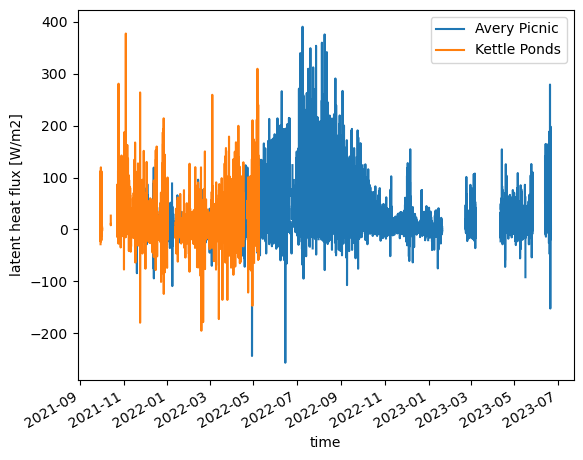

In [7]:
splash_ap_ds['Hl'].plot(label='Avery Picnic')
splash_kp_ds['Hl'].plot(label='Kettle Ponds')
plt.legend()

In [8]:
# let's build a function to qc all the data quickly
VARIABLES = ['atmos_pressure','temp','rh','vapor_pressure','skin_temp_surface','wspd_u_mean','wspd_v_mean','wspd_w_mean','wspd_vec_mean','wdir_vec_mean']
def qc_splash_met(ds, variables, temp_var, rh_var, wspd_var, vapor_pressure_var):
    # first let's add qc to all the variables as a new list
    qc_variables = [v+'_qc' for v in variables]
    ds_qc = ds#[variables+qc_variables]
    # now if any qc variable is not 0, we will set the variable to nan
    for v in variables:
        ds_qc[v] = ds_qc[v].where(ds_qc[v+'_qc']==0, other=np.nan)
    # now let's drop the qc variables
    ds_qc = ds_qc.drop_vars(qc_variables)
    # now let's set extreme values for certain variables
    temp_max = 30
    temp_min = -40
    rh_min = 0
    wspd_max = 40 # max in m/s
    vapor_pressure_max = 7.835 # this is the saturation vapor pressure at 40C
    # now let's filter out the extremes and fill with nan
    ds_qc[temp_var] = ds_qc[temp_var].where((ds_qc[temp_var]<temp_max) & (ds_qc[temp_var]>temp_min), other=np.nan)
    if rh_var == 'rh_mean':
        ds_qc['rh_mean'] = ds_qc['rh_mean'].where(ds_qc['rh_mean']>rh_min, other=np.nan)
    ds_qc[wspd_var] = ds_qc[wspd_var].where(ds_qc[wspd_var]<wspd_max, other=np.nan)
    ds_qc[vapor_pressure_var] = ds_qc[vapor_pressure_var].where(ds_qc[vapor_pressure_var]<vapor_pressure_max, other=np.nan)
    # count how many data points are nan for each variable and print that out
    for v in variables:
        print(f'{v} has {ds_qc[v].isnull().sum().values} nan values')
    print('-------------------')
    # return the qc'd dataset
    return ds_qc


In [51]:
splash_ap_qc_ds = qc_splash_met(splash_ap_ds, VARIABLES, 'temp', 'rh', 'wspd_vec_mean', 'vapor_pressure')
splash_kp_qc_ds = qc_splash_met(splash_kp_ds, VARIABLES, 'temp', 'rh', 'wspd_vec_mean', 'vapor_pressure')

atmos_pressure has 8464 nan values
temp has 8464 nan values
rh has 8464 nan values
vapor_pressure has 88992 nan values
skin_temp_surface has 9256 nan values
wspd_u_mean has 11175 nan values
wspd_v_mean has 11175 nan values
wspd_w_mean has 11175 nan values
wspd_vec_mean has 11204 nan values
wdir_vec_mean has 11204 nan values
-------------------
atmos_pressure has 2493 nan values
temp has 2493 nan values
rh has 2507 nan values
vapor_pressure has 95040 nan values
skin_temp_surface has 4498 nan values
wspd_u_mean has 10970 nan values
wspd_v_mean has 10970 nan values
wspd_w_mean has 10970 nan values
wspd_vec_mean has 10986 nan values
wdir_vec_mean has 10986 nan values
-------------------


In [52]:
# resample to hourly average
# save the attributes
attrs = splash_ap_qc_ds.attrs
splash_ap_qc_ds_hourly = splash_ap_qc_ds.to_dataframe().resample('1H').mean().to_xarray()
splash_kp_qc_ds_hourly = splash_kp_qc_ds.to_dataframe().resample('1H').mean().to_xarray()
splash_ap_qc_ds_hourly.attrs = attrs
splash_kp_qc_ds_hourly.attrs = attrs
# replace the wdir_vec_mean with the wind direction mean from the u and v components
def resampled_wind_dir(u, v):
    dir = 270-np.rad2deg(np.arctan2(v,u))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    return dir
splash_ap_qc_ds_hourly['wdir_vec_mean'] = resampled_wind_dir(splash_ap_qc_ds_hourly['wspd_u_mean'],splash_ap_qc_ds_hourly['wspd_v_mean'])
splash_kp_qc_ds_hourly['wdir_vec_mean'] = resampled_wind_dir(splash_kp_qc_ds_hourly['wspd_u_mean'],splash_kp_qc_ds_hourly['wspd_v_mean'])

# filter to the two water years
w23_splash_ap_qc_ds_1H = splash_ap_qc_ds_hourly.sel(time=slice('2022-12-01','2023-03-31'))
w22_splash_ap_qc_ds_1H = splash_ap_qc_ds_hourly.sel(time=slice('2021-12-01','2022-03-31'))
w23_splash_kp_qc_ds_1H = splash_kp_qc_ds_hourly.sel(time=slice('2022-12-01','2023-03-31'))
w22_splash_kp_qc_ds_1H = splash_kp_qc_ds_hourly.sel(time=slice('2021-12-01','2022-03-31'))


### 2022

In [55]:
df = w22_splash_ap_qc_ds_1H[['wspd_vec_mean','wdir_vec_mean']].to_dataframe()
# create a windrose dataframe
splash_windrose_df = create_windrose_df(df, wind_dir_var='wdir_vec_mean', wind_spd_var='wspd_vec_mean')

# create a wind rose plot using bar_polar
fig = px.bar_polar(splash_windrose_df, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title="Daily Avg Wind Rose at 3.8 m on SPLASH ASFS Station, 2022",
    font_size=12,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 30]
      ),
)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


### 2023

In [56]:
df = w23_splash_ap_qc_ds_1H[['wspd_vec_mean','wdir_vec_mean']].to_dataframe()
# create a windrose dataframe
splash_windrose_df = create_windrose_df(df, wind_dir_var='wdir_vec_mean', wind_spd_var='wspd_vec_mean')

# create a wind rose plot using bar_polar
fig = px.bar_polar(splash_windrose_df, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title="Daily Avg Wind Rose at 3.8 m on SPLASH ASFS Station, 2023",
    font_size=12,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 30]
      ),
)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


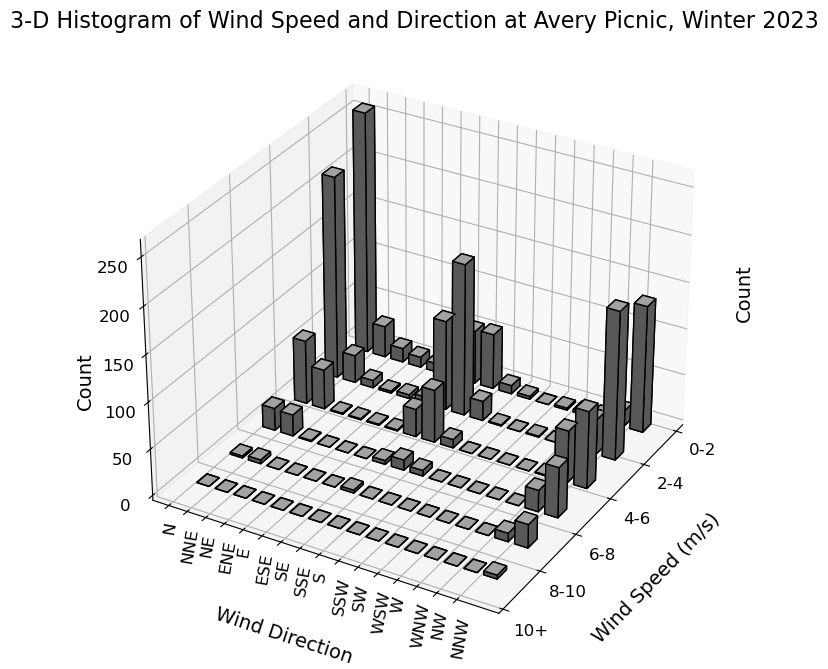

In [60]:
location = 'ap'
if location=='ap':
    ds = w23_splash_ap_qc_ds_1H
    wspd_var = 'wspd_vec_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp'
    title = 'Avery Picnic'
elif location=='kp':
    ds = w23_splash_kp_qc_ds_1H
    wspd_var = 'wspd_vec_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp'
    title = 'Kettle Ponds'
df_to_use = ds.to_dataframe()
timestep=1

df_test = df_to_use[[wspd_var, wdir_var, temp_var]]
# create a 3d histogram in matplotlib to show the relationship between wind speed, wind direction, and total sublimation
# To generate some test data
xAmplitudes = df_test[wspd_var]#your data here
yAmplitudes = df_test[wdir_var]#your other data here


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(xAmplitudes, yAmplitudes, bins=[6,16], range=[[0, 10], [0, 360]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1]+6.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = 0.5*np.ones_like(zpos)
dy = 15 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='max', color='lightgrey', ec='black')
# rotate the plot
ax.view_init(30, 30,0)
# replace y-axis labels with cardinal wind direction lables
ax.set_yticks([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
ax.set_yticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'], rotation=80, fontsize=12, ha='left')

ax.set_xticks([0,2,4,6,8,10,])
ax.set_xticklabels(['0-2','2-4','4-6','6-8','8-10','10+'], rotation=0, fontsize=12, ha='center', va='bottom')
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=0)
# increase tick label size on zaxis
ax.tick_params(axis='z', labelsize=12)
# ax.set_zlim(0,40)
# show z-axis on the right
ax.zaxis.set_rotate_label(False)
ax.zaxis.set_label_position('both')

ax.set_zlabel('Count', rotation=90, fontsize=14)
ax.set_xlabel('Wind Speed (m/s)', fontsize=14)
ax.set_ylabel('Wind Direction', fontsize=14)
ax.set_title(f'3-D Histogram of Wind Speed and Direction at {title}, Winter 2023', fontsize=16)
# pad the x-axis label
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

plt.show()

### Seasonal Sublimation

In [91]:
# latent heat of sublimation
Ls = 2834.1e3 # J/g
# latent heat of vaporization
Lv = 2500.1e3 # J/g
# density of water
rho_w = 1 # g/cm^3

# calculate the sublimation rate when the temperature is below 0C and evaporation rate when the temperature is above 0C
splash_ap_qc_ds['e_rate']=(splash_ap_qc_ds['Hl'] *3600 * 1000/ 1000 / Ls/6)
splash_kp_qc_ds['e_rate']=(splash_kp_qc_ds['Hl'] *3600 * 1000/ 1000 / Ls/6)

w23_splash_ap_qc_ds_1H['e_rate']=(w23_splash_ap_qc_ds_1H['Hl'] *3600 * 1000/ 1000 / Ls)
w22_splash_ap_qc_ds_1H['e_rate']=(w22_splash_ap_qc_ds_1H['Hl'] *3600 * 1000/ 1000 / Ls)

w23_splash_kp_qc_ds_1H['e_rate']=(w23_splash_kp_qc_ds_1H['Hl'] *3600 * 1000/ 1000 / Ls)
w22_splash_kp_qc_ds_1H['e_rate']=(w22_splash_kp_qc_ds_1H['Hl'] *3600 * 1000/ 1000 / Ls)

In [145]:
splash_kp_qc_ds.sel(time=slice('2022-04-01','2022-05-15'))['e_rate'].sum()

<xarray.DataArray 'e_rate' ()>
array(16.87902463)

In [127]:
# caclulate and plot the cumulative sum of e_rate
ds = xr.open_dataset('../../01_data/processed_data/sos_daily_h2o_flux_cleaned.nc')
# ecor_ds.e_rate.cumsum().plot()
cumulative_sos_sublimation = ds.cumsum(dim='time')
# scatter plot of e_rate vs ds['w_h2o__3m_uw']
df1 = splash_ap_qc_ds['e_rate'].sel(time=slice('2022-12-01','2023-03-31')).to_dataframe().dropna().resample('1D').sum()
df1 = df1[df1!=0]
df2 = ds['w_h2o__3m_uw'].sel(time=slice('2022-12-01','2023-03-31')).to_dataframe()
df = pd.concat([df1, df2], axis=1)

fig = px.scatter(df, 
                 x='w_h2o__3m_uw', 
                 y='e_rate', 
                 title='SPLASH (Avery Picnic) vs SOS Daily Sublimation on UW Tower',
                 trendline='ols',)
# add black edges to markers
fig.update_traces(marker=dict(line=dict(width=1, color='black'), size=10))
# add 1:1 line
fig.add_trace(go.Scatter(x=[-0.1, 1.5], y=[-0.1, 1.5], mode='lines', name='1:1 Line', line=dict(color='black', dash='dash')))
fig.update_layout(
    xaxis_title='SOS 10m Sublimation Rate (mm/day)',
    yaxis_title='SPLASH Sublimation Rate (mm/day)',
    width=800,
    height=600,
)

### Make Heatmaps Sublimation with Wind Speed and Direction

### 2022

In [137]:
location = 'kp'
if location=='kp':
    ds = w22_splash_kp_qc_ds_1H
    # replace mean_t with the temp_mean value from w22_saile_met_qc_ds_1H
    wspd_var = 'wspd_vec_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp'
    title = 'Kettle Ponds'
elif location=='ap':
    ds = w22_splash_ap_qc_ds_1H
    wspd_var = 'wspd_vec_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp'
    title = 'Avery Picnic'
df_to_use = ds.to_dataframe()
timestep=1

df_test = df_to_use[[wspd_var, wdir_var, temp_var]]
# lets add sublimation to the dataframe
df_test['sublimation'] = ds['e_rate'].sel(time=slice('2021-12-01','2022-03-31'))

In [135]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[wspd_var], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[wdir_var], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).sum()[f'sublimation']
# unstack and put into a dataframe
grouped =(grouped.unstack())

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


15.183291073472514

In [120]:
# plot grouped as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped.values, 
                         x=grouped.columns, 
                         y=grouped.index,

                        colorbar={'title':'Sublimation<br>(mm)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-2,
                        zmax=2,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Sublimation<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [132]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=splash_ap_qc_ds['e_rate'].sel(time=slice('2021-11-30','2022-05-09')).resample(time='1D').sum().cumsum().time, 
                         y= splash_ap_qc_ds['e_rate'].sel(time=slice('2021-11-30','2022-05-09')).resample(time='1D').sum().cumsum().values, 
                         name='SPLASH Sublimation (Avery Picnic)', 
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=splash_kp_qc_ds['e_rate'].sel(time=slice('2021-11-30','2022-05-09')).resample(time='1D').sum().cumsum().time, 
                         y= splash_kp_qc_ds['e_rate'].sel(time=slice('2021-11-30','2022-05-09')).resample(time='1D').sum().cumsum().values, 
                         name='SPLASH Sublimation (Kettle Ponds)', 
                         line=dict(color='purple')))

# make a 4 color red colorramp from pink to red
fig.update_layout(title='Cumulative Sublimation for SPLASH Kettle Ponds and Avery Picnic, Winter 2022',
                    xaxis_title='Date',
                    yaxis_title='Cumulative Sublimation (mm)',
                    width=1000,
                    height=600,
                    legend_title='Site')

In [149]:

# scatter plot of e_rate vs ds['w_h2o__3m_uw']
df1 = splash_ap_qc_ds['e_rate'].sel(time=slice('2021-12-01','2022-03-31')).to_dataframe().dropna().resample('1D').sum()
df1 = df1[df1!=0]
df1 = df1.rename(columns={'e_rate':'ap'})
df2 = splash_kp_qc_ds['e_rate'].sel(time=slice('2021-12-01','2022-03-31')).to_dataframe().dropna().resample('1D').sum()
df2 = df2[df2!=0]
df2 = df2.rename(columns={'e_rate':'kp'})
df = pd.concat([df1, df2], axis=1)

fig = px.scatter(df, 
                 x='ap', 
                 y='kp', 
                 title='SPLASH (Avery Picnic) vs SPLASH (Kettle Ponds) Daily Sublimation, Winter 2022',
                 trendline='ols',)
# add black edges to markers
fig.update_traces(marker=dict(line=dict(width=1, color='black'), size=10))
# add 1:1 line
fig.add_trace(go.Scatter(x=[-0.1, 1.], y=[-0.1, 1.], mode='lines', name='1:1 Line', line=dict(color='black', dash='dash')))
fig.update_layout(
    xaxis_title='Avery Picnic Sublimation Rate (mm/day)',
    yaxis_title='Kettle Ponds Sublimation Rate (mm/day)',
    width=800,
    height=600,
)

### 2023

In [154]:
location = 'ap'
if location=='kp':
    ds = w23_splash_kp_qc_ds_1H
    # replace mean_t with the temp_mean value from w22_saile_met_qc_ds_1H
    wspd_var = 'wspd_vec_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp'
    title = 'Kettle Ponds'
elif location=='ap':
    ds = w23_splash_ap_qc_ds_1H
    wspd_var = 'wspd_vec_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp'
    title = 'Avery Picnic'
df_to_use = ds.to_dataframe()
timestep=1

df_test = df_to_use[[wspd_var, wdir_var, temp_var]]
# lets add sublimation to the dataframe
df_test['sublimation'] = ds['e_rate'].sel(time=slice('2022-12-01','2023-03-31'))

In [155]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[wspd_var], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[wdir_var], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).sum()[f'sublimation']
# unstack and put into a dataframe
grouped =(grouped.unstack())
df_test['sublimation'].sum()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


7.027575521347806

Sublimation at Avery Picnic 

In [156]:
# plot grouped as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped.values, 
                         x=grouped.columns, 
                         y=grouped.index,

                        colorbar={'title':'Sublimation<br>(mm)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-2,
                        zmax=2,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Sublimation<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

Temperature

In [159]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[wspd_var], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[wdir_var], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).mean()[f'temp']
# unstack and put into a dataframe
grouped =(grouped.unstack())

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [163]:
# plot grouped as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped.values, 
                         x=grouped.columns, 
                         y=grouped.index,

                        colorbar={'title':'Temperature<br>(&deg;C)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-12,
                        zmax=0,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Sublimation<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [130]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=splash_ap_qc_ds['e_rate'].sel(time=slice('2022-11-30','2023-05-09')).resample(time='1D').sum().cumsum().time, 
                         y= splash_ap_qc_ds['e_rate'].sel(time=slice('2022-11-30','2023-05-09')).resample(time='1D').sum().cumsum().values, 
                         name='SPLASH ECOR Sublimation (Avery Picnic)', 
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=splash_kp_qc_ds['e_rate'].sel(time=slice('2022-11-30','2023-05-09')).resample(time='1D').sum().cumsum().time, 
                         y= splash_kp_qc_ds['e_rate'].sel(time=slice('2022-11-30','2023-05-09')).resample(time='1D').sum().cumsum().values, 
                         name='SPLASH ECOR Sublimation (Kettle Ponds)', 
                         line=dict(color='purple')))

# make a 4 color red colorramp from pink to red
color_ramp_1 = px.colors.sequential.Reds[2:6]                      
color_ramp_2 = px.colors.sequential.Greens[2:6]
for i, loc in enumerate(['uw','ue','d','c']):
    fig.add_trace(go.Scatter(x=ds.time,
                                y=cumulative_sos_sublimation[f'w_h2o__10m_{loc}'].values,
                                name=f'SOS Sublimation (10m {loc})',
                                line=dict(color=color_ramp_1[i])))
    fig.add_trace(go.Scatter(x=ds.time,
                                y=cumulative_sos_sublimation[f'w_h2o__3m_{loc}'].values,
                                name=f'SOS Sublimation (3m {loc})',
                                line=dict(color=color_ramp_2[i])))
fig.update_layout(title='Cumulative Sublimation at SPLASH and SOS Sites',
                    xaxis_title='Date',
                    yaxis_title='Cumulative Sublimation (mm)',
                    width=1000,
                    height=600,
                    legend_title='Site')